In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

C:\Users\omexj\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'D:\\jagadish VIT\\3rd YEAR\\SEM 6\\Deep Learning\\DL PROJECT\\dataset_new'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

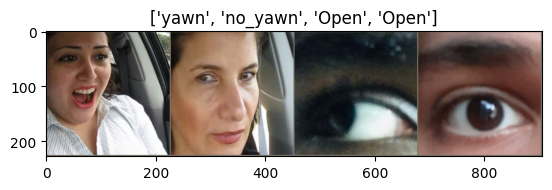

In [3]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 5)

#model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=10)

Epoch 0/9
----------
train Loss: 0.6754 Acc: 0.7406
test Loss: 0.0543 Acc: 0.9864

Epoch 1/9
----------
train Loss: 0.3666 Acc: 0.8745
test Loss: 0.0114 Acc: 0.9949

Epoch 2/9
----------
train Loss: 0.2829 Acc: 0.9004
test Loss: 0.0224 Acc: 0.9932

Epoch 3/9
----------
train Loss: 0.2570 Acc: 0.9206
test Loss: 0.0217 Acc: 0.9966

Epoch 4/9
----------
train Loss: 0.2695 Acc: 0.9103
test Loss: 0.0249 Acc: 0.9898

Epoch 5/9
----------
train Loss: 0.2102 Acc: 0.9298
test Loss: 0.0317 Acc: 0.9949

Epoch 6/9
----------
train Loss: 0.2263 Acc: 0.9142
test Loss: 0.0122 Acc: 0.9949

Epoch 7/9
----------
train Loss: 0.1769 Acc: 0.9332
test Loss: 0.0072 Acc: 0.9983

Epoch 8/9
----------
train Loss: 0.1485 Acc: 0.9443
test Loss: 0.0077 Acc: 0.9983

Epoch 9/9
----------
train Loss: 0.1549 Acc: 0.9447
test Loss: 0.0108 Acc: 0.9983

Training complete in 70m 52s
Best val Acc: 0.998296


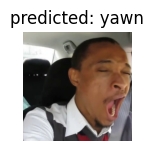

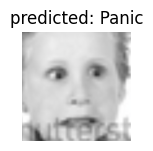

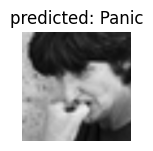

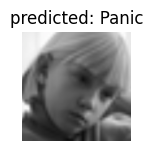

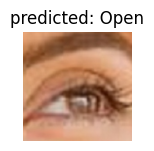

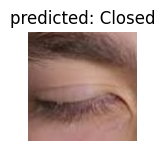

In [8]:
visualize_model(model_ft)

In [9]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 5)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [10]:
model_conv = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.8391 Acc: 0.6566
test Loss: 0.2911 Acc: 0.8467

Epoch 1/9
----------
train Loss: 0.6997 Acc: 0.7230
test Loss: 0.2971 Acc: 0.8859

Epoch 2/9
----------
train Loss: 0.6776 Acc: 0.7383
test Loss: 0.2139 Acc: 0.9029

Epoch 3/9
----------
train Loss: 0.6057 Acc: 0.7505
test Loss: 0.2042 Acc: 0.9233

Epoch 4/9
----------
train Loss: 0.5970 Acc: 0.7528
test Loss: 0.2278 Acc: 0.9063

Epoch 5/9
----------
train Loss: 0.6048 Acc: 0.7627
test Loss: 0.3837 Acc: 0.8705

Epoch 6/9
----------
train Loss: 0.6267 Acc: 0.7543
test Loss: 0.1979 Acc: 0.9182

Epoch 7/9
----------
train Loss: 0.5008 Acc: 0.7936
test Loss: 0.2074 Acc: 0.9148

Epoch 8/9
----------
train Loss: 0.4989 Acc: 0.7940
test Loss: 0.2253 Acc: 0.9114

Epoch 9/9
----------
train Loss: 0.5213 Acc: 0.7902
test Loss: 0.1943 Acc: 0.9165

Training complete in 40m 50s
Best val Acc: 0.923339


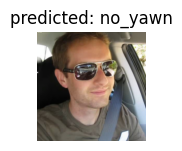

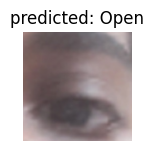

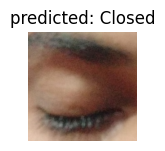

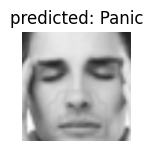

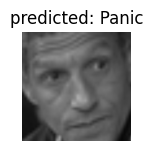

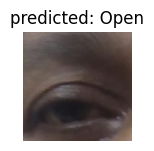

In [11]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [12]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['test'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)


In [ ]:
#model.save("drowiness_new7.h5")

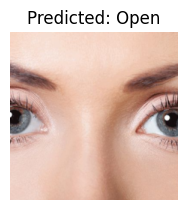

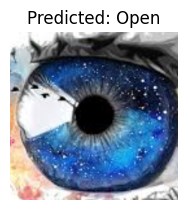

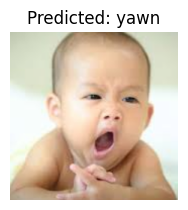

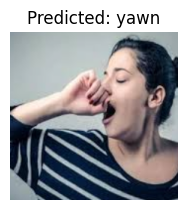

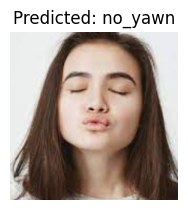

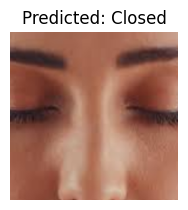

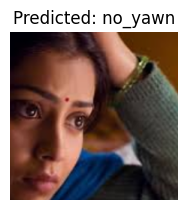

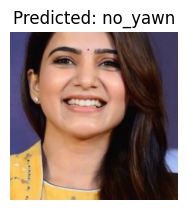

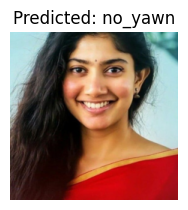

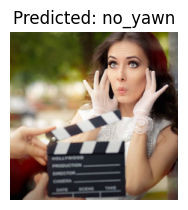

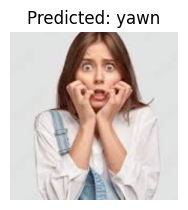

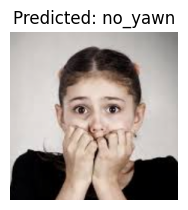

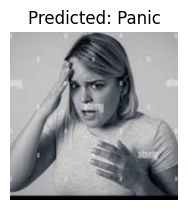

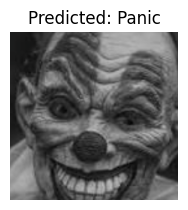

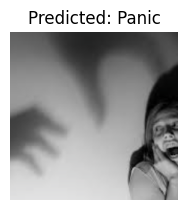

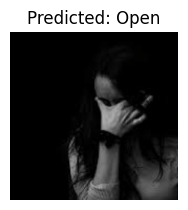

In [28]:
visualize_model_predictions(model_conv,img_path='D:\\jagadish VIT\\3rd YEAR\\SEM 6\\Deep Learning\\DL PROJECT\\test images\\opened.jpeg')
visualize_model_predictions(model_conv,img_path='D:\\jagadish VIT\\3rd YEAR\\SEM 6\\Deep Learning\\DL PROJECT\\test images\\opened1.jpeg')
visualize_model_predictions(model_conv,img_path='D:\\jagadish VIT\\3rd YEAR\\SEM 6\\Deep Learning\\DL PROJECT\\test images\\yawn.jpeg')
visualize_model_predictions(model_conv,img_path='D:\\jagadish VIT\\3rd YEAR\\SEM 6\\Deep Learning\\DL PROJECT\\test images\\yawn1.jpeg')
visualize_model_predictions(model_conv,img_path='D:\\jagadish VIT\\3rd YEAR\\SEM 6\\Deep Learning\\DL PROJECT\\test images\\closed.jpeg')
visualize_model_predictions(model_conv,img_path='D:\\jagadish VIT\\3rd YEAR\\SEM 6\\Deep Learning\\DL PROJECT\\test images\\closed1.jpeg')
visualize_model_predictions(model_conv,img_path='D:\\jagadish VIT\\3rd YEAR\\SEM 6\\Deep Learning\\DL PROJECT\\test images\\no yawn.jpeg')
visualize_model_predictions(model_conv,img_path='D:\\jagadish VIT\\3rd YEAR\\SEM 6\\Deep Learning\\DL PROJECT\\test images\\happy1.jpg')
visualize_model_predictions(model_conv,img_path='D:\\jagadish VIT\\3rd YEAR\\SEM 6\\Deep Learning\\DL PROJECT\\test images\\happy2.jpg')
visualize_model_predictions(model_ft,img_path='D:\\jagadish VIT\\3rd YEAR\\SEM 6\\Deep Learning\\DL PROJECT\\test images\\panic.jpg')
visualize_model_predictions(model_ft,img_path='D:\\jagadish VIT\\3rd YEAR\\SEM 6\\Deep Learning\\DL PROJECT\\test images\\panic.jpeg')
visualize_model_predictions(model_ft,img_path='D:\\jagadish VIT\\3rd YEAR\\SEM 6\\Deep Learning\\DL PROJECT\\test images\\panic1.jpeg')
visualize_model_predictions(model_ft,img_path='D:\\jagadish VIT\\3rd YEAR\\SEM 6\\Deep Learning\\DL PROJECT\\test images\\fear.jpeg')
visualize_model_predictions(model_ft,img_path='D:\\jagadish VIT\\3rd YEAR\\SEM 6\\Deep Learning\\DL PROJECT\\test images\\f1.jpeg')
visualize_model_predictions(model_ft,img_path='D:\\jagadish VIT\\3rd YEAR\\SEM 6\\Deep Learning\\DL PROJECT\\test images\\f2.jpeg')
visualize_model_predictions(model_ft,img_path='D:\\jagadish VIT\\3rd YEAR\\SEM 6\\Deep Learning\\DL PROJECT\\test images\\f3.jpeg')
plt.ioff()
plt.show()